# Semi_Supervised

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.semi_supervised import LabelSpreading
from pyod.models.knn import KNN
from pyod.models.xgbod import XGBOD

import warnings
warnings.filterwarnings("ignore") # отключение варнингов

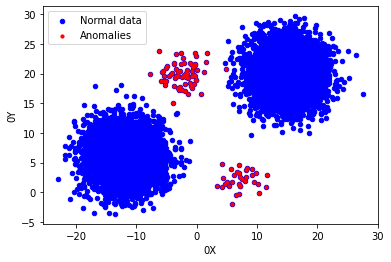

In [57]:
contamination = 0.01  # % (percentage) of outliers
n_train = 10000  # number of training points
n_test_size = 0.3  # %  (percentage)  of testing points
n_features = 2 # Number of features
n_train_semi_size = 0.15

n_out = int(n_train*contamination) # число выбросов
n_out_1 = int(n_out/3)
n_out_2 = n_out - (n_out_1)

np.random.RandomState(42)
np.random.seed(40)
from sklearn.datasets import make_blobs

centers = [[-12, 6], [15, 20]] #anomal
           
X = make_blobs(n_samples=n_train, n_features=n_features, centers=centers, random_state=1,
               cluster_std=3)[0] # center_box=(-10.0, 10.0)
#X[:n_out,:] = 10*np.random.rand(n_out, 2)-10
#Первый центр выбросов
X[:n_out_1,:] = np.random.normal(7, 2, size=(n_out_1, 2))
X[:n_out_1,1]  = X[:n_out_1,1] - 5
#Второй центр выбросов
X[n_out_1:n_out,:] = np.random.normal(10, 2, size=(n_out_2, 2))
X[n_out_1:n_out,1] = X[n_out_1:n_out,1] +10 
X[n_out_1:n_out,0] = X[n_out_1:n_out,0] -12

y = np.zeros(n_train)
y[:n_out] = 1
plt.scatter(X[:,0], X[:,1], c='#0000FF',s=20, label='Normal data')
plt.scatter(X[:n_out,0], X[:n_out,1], c='#FF0000', s=10, label='Anomalies')
plt.xlabel(u'0X')
plt.ylabel('0Y')
plt.legend()

Text(0.5, 1.0, 'Feature y')

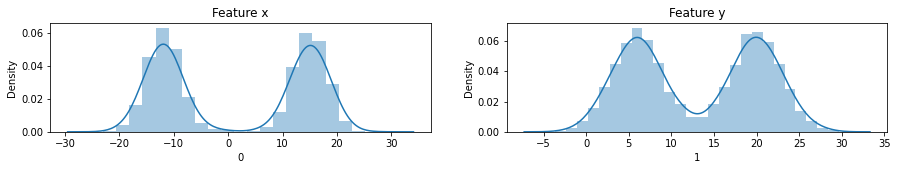

In [58]:
data = pd.DataFrame(X)
data.columns =['0', '1'] 
fig, ax = plt.subplots(figsize=(15,2), ncols=2, nrows=1)
sns.distplot(data['0'], ax=ax[0])
sns.distplot(data['1'], ax=ax[1])
ax[0].set_title("Feature x")
ax[1].set_title("Feature y")

#### TRAIN and TEST data preparation

In [59]:
df = pd.DataFrame(X)
df['y'] =y 
df = shuffle(df, random_state=1)
train, test = train_test_split(df, test_size=n_test_size, random_state=1)
train_semi, valid_semi = train_test_split(train, test_size=n_train_semi_size, random_state=1)

In [60]:
valid_semi.shape

(1050, 3)

traine_outlier: 1.09 %
test_outlier:   0.80 % 


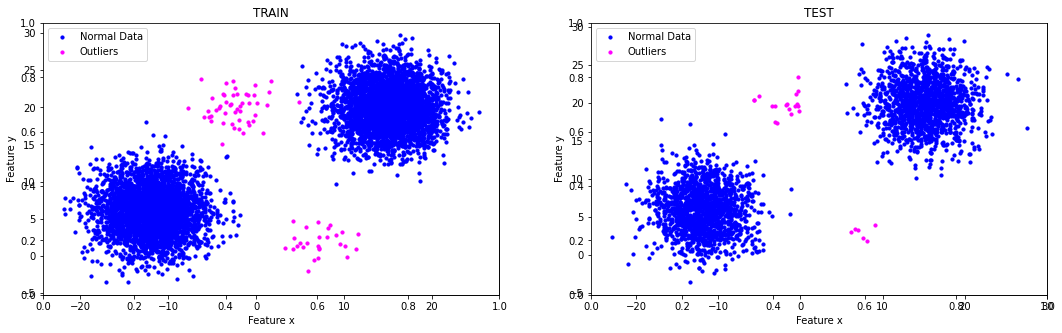

In [61]:
fig, ax = plt.subplots(figsize=(18,5), nrows=1, ncols=2)

train_in = train[train.y==0.0]
train_out = train[train.y==1.0]
plt.subplot(121)
ax = fig.add_subplot(121)
plt.scatter(train_in.iloc[:,0], train_in.iloc[:,1], c='#0000FF', s = 10, label='Normal Data')
plt.scatter(train_out.iloc[:,0], train_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.title('TRAIN')
plt.legend()


test_in = test[test.y==0.0]
test_out = test[test.y==1.0]
plt.subplot(122)
ax = fig.add_subplot(122)
plt.scatter(test_in.iloc[:,0], test_in.iloc[:,1], c='#0000FF', s = 10, label='Normal Data')
plt.scatter(test_out.iloc[:,0], test_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.title('TEST')
plt.legend()

print(f"traine_outlier: {len(train[train.y==1])*100/len(train):4.2f} %")
print(f"test_outlier:   {len(test[test.y==1])*100/len(test):4.2f} % ")

In [62]:
X_train = train.iloc[:,:-1].copy()
y_train = train.iloc[:,2].copy()

X_test = test.iloc[:,:-1].copy()
y_test= test.iloc[:,2].copy()

X_valid_semi= valid_semi.iloc[:,:-1].copy()
y_valid_semi = valid_semi.iloc[:,2].copy()

X_train.index = np.arange(len(X_train))
X_test.index = np.arange(len(X_test))
X_valid_semi.index = np.arange(len(X_valid_semi))

y_train.index = np.arange(len(y_train))
y_test.index = np.arange(len(y_test))
y_valid_semi.index = np.arange(len(y_valid_semi))

In [63]:
# scaler
scaler = RobustScaler()

data_X_train = pd.DataFrame(X_train)
data_X_train.columns =['0', '1'] 

data_X_test = pd.DataFrame(X_test)
data_X_test.columns =['0', '1'] 

data_X_valid_semi = pd.DataFrame(X_valid_semi)
data_X_valid_semi.columns =['0', '1'] 

data_features_train = X_train.iloc[:, :]
data_features_test = X_test.iloc[:, :]
data_features_valid_semi = X_valid_semi.iloc[:, :]

scaled_data_train = pd.DataFrame(
    data=scaler.fit_transform(data_features_train), 
    columns=data_features_train.columns
)
scaled_data_test = pd.DataFrame(
    data=scaler.fit_transform(data_features_test), 
    columns=data_features_test.columns
)
scaled_data_valid_semi = pd.DataFrame(
    data=scaler.fit_transform(data_features_valid_semi), 
    columns=data_features_valid_semi.columns
)

In [64]:
def vizualisation_methods_test(test, labeled_data_test, name_method):

    fig, ax = plt.subplots(figsize=(12,3), nrows=1, ncols=2)

#Тестовая выборка Original
    test_in = test[test.y==0.0]
    test_out = test[test.y==1.0]
    plt.subplot(121)
    ax = fig.add_subplot(121)
    plt.scatter(test_in.iloc[:,0], test_in.iloc[:,1], c='#0000FF', s = 10, label='Normal data')
    plt.scatter(test_out.iloc[:,0], test_out.iloc[:,1], c='#FF00FF', s = 10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title('TEST Original')
    plt.legend()

    plt.subplot(122)
    ax = fig.add_subplot(122)
    plt.scatter(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == False], 
            labeled_data_test.iloc[:,1][labeled_data_test['is_outlier'] == False], c='#0000FF',s=10, label='Normal data')
    
    plt.scatter(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == True],
            labeled_data_test.iloc[:,1][labeled_data_test['is_outlier'] == True], c='#FF0000', s=10, label='Outliers')
    plt.xlabel('Feature x')
    plt.ylabel('Feature y')
    plt.title(name_method)
    plt.legend()
    print(f"Data outlier percentage: Original TEST - {contamination*100} %;                           {name_method} - {100 - 100*len(labeled_data_test.iloc[:,0][labeled_data_test['is_outlier'] == False])/len(test):4.2f} %")

In [65]:
def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:           {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

#### KNN

In [13]:
n_neighbors = 10
knn = KNN(contamination = contamination, n_neighbors = n_neighbors)
knn.fit(scaled_data_train)

knn_outliers_train = knn.predict(scaled_data_train)
#knn_outliers_train = np.array([1 if label == 1 else 0 for label in isolation_outliers_train])

anomalies_report(knn_outliers_train)
print(f"f1_score_for_Train:  {f1_score(y_train, knn_outliers_train, average='binary'):6.4f}")

Total number of outliers: 57
Percentage of outliers:           0.81%
f1_score_for_Train:  0.4361


In [14]:
#isolation_forest.fit(scaled_data_test)
knn_outliers_test = knn.predict(scaled_data_test)
#knn_outliers_test = np.array([1 if label == -1 else 0 for label in isolation_outliers_test])
anomalies_report(knn_outliers_test)
print(f"f1_score_for_Test:  {f1_score(y_test, knn_outliers_test, average='binary'):6.4f}")

Total number of outliers: 25
Percentage of outliers:           0.83%
f1_score_for_Test:  0.2857


Data outlier percentage: Original TEST - 1.0 %;                           knn - for Test - 0.83 %


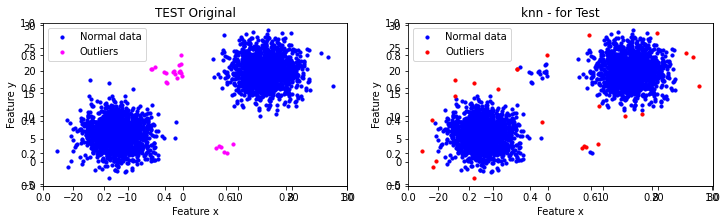

In [15]:
data_features = data.iloc[:, :]
labeled_data_test = data_features_test.copy()

labeled_data_test['is_outlier'] = knn_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'knn - for Test')

### Semi_Supervised  LabelPropagation

In [16]:
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import f1_score

In [17]:
rng = np.random.RandomState(42)
f1_score_lp_train = []
f1_score_lp_test = []
array_step = []
step = 0.01
while step < 1:
    step = np.around(step, decimals=2)
    y_h = np.copy(y_train)
    y_h[rng.rand(len(y_train)) <= step] = -1
    ls_h = LabelPropagation().fit(scaled_data_train, y_h)
    
    semi_outliers_train = ls_h.predict(scaled_data_train)
    f1_score_lp_train.append(f1_score(y_train, semi_outliers_train, average='binary'))
    
    semi_outliers_test = ls_h.predict(scaled_data_test)
    f1_score_lp_test.append(f1_score(y_test, semi_outliers_test, average='binary'))
    
    array_step.append(step)
    step += 0.05

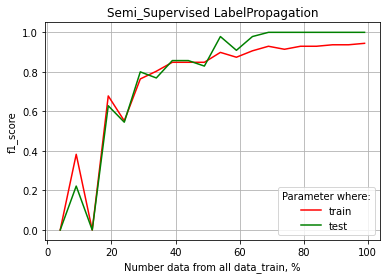

In [19]:
condition = lambda x: (1-x)*100
vfunc = np.vectorize(condition)
res_lp = vfunc(array_step)

fig, ax = plt.subplots()
ax.plot(res_lp, f1_score_lp_train, color='red', label='train')
ax.plot(res_lp, f1_score_lp_test, color='green', label='test')
ax.set(xlabel='Number data from all data_train, %', ylabel='f1_score',
       title='Semi_Supervised LabelPropagation')
ax.grid()
plt.legend(title='Parameter where:')
plt.show()

### Semi_Supervised LabelSpreading

In [20]:
rng = np.random.RandomState(42)
f1_score_ls_train = []
f1_score_ls_test = []
array_step = []
step = 0.001
while step < 1:
    step = np.around(step, decimals=2)
    y_h = np.copy(y_train)
    y_h[rng.rand(len(y_train)) < step] = -1
    ls_h = LabelSpreading(kernel='rbf').fit(scaled_data_train, y_h)
    
    semi_outliers_train = ls_h.predict(scaled_data_train)
    f1_score_ls_train.append(f1_score(y_train, semi_outliers_train, average='binary'))
    
    semi_outliers_test = ls_h.predict(scaled_data_test)
    f1_score_ls_test.append(f1_score(y_test, semi_outliers_test, average='binary'))
    
    array_step.append(step)
    step += 0.05

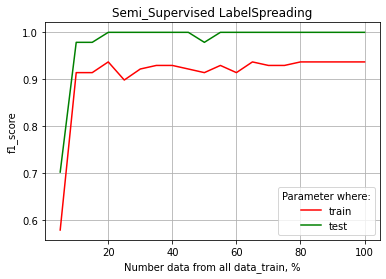

In [21]:
condition = lambda x: (1-x)*100
vfunc = np.vectorize(condition)
res_ls = vfunc(array_step)

fig, ax = plt.subplots()
ax.plot(res_ls, f1_score_ls_train, color='red', label='train')
ax.plot(res_ls, f1_score_ls_test, color='green', label='test')
ax.set(xlabel='Number data from all data_train, %', ylabel='f1_score',
       title='Semi_Supervised LabelSpreading')
ax.grid()
plt.legend(title='Parameter where:')
plt.show()

Data outlier percentage: Original TEST - 1.0 %;                           Semi_Supervised - for Test - 0.43 %


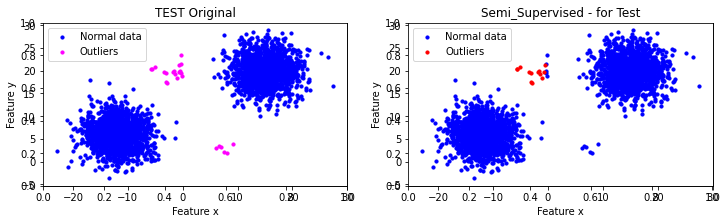

In [22]:
data_features = data.iloc[:, :]
labeled_data_test = data_features_test.copy()

labeled_data_test['is_outlier'] = semi_outliers_test
vizualisation_methods_test(test, labeled_data_test, 'Semi_Supervised - for Test')

### XGBOD

In [23]:
xgbod = XGBOD(contamination=contamination)
f1_score_xgbod_valid, f1_score_xgbod_test = [], []
array_step = []
step = 0.01
while step <= 1:
    step = np.around(step, decimals=2)
    scaled_data_train_semi, scaled_data_valid_semi, y_train_semi, y_valid_semi = train_test_split(scaled_data_train, 
                                                                                              y_train, test_size=step, 
                                                                                              random_state=42)
    xgbod.fit(scaled_data_valid_semi, y_valid_semi)
    semi_outliers_valid = xgbod.predict(scaled_data_valid_semi)
    semi_outliers_test = xgbod.predict(scaled_data_test)
      
    f1_score_xgbod_valid.append(f1_score(y_valid_semi,  semi_outliers_valid, average='binary'))
    f1_score_xgbod_test.append(f1_score(y_test, semi_outliers_test, average='binary'))
    
    array_step.append(step)
    print(step)
    step += 0.05

[16:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

0.01
[16:29:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

0.06
[16:29:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

0.11
[16:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "contamination", "silent" } are not used.

0.16
[16:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-w

Size of test 3000


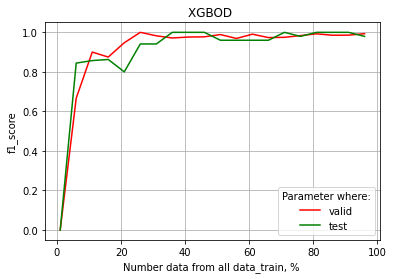

In [25]:
condition = lambda x: x*scaled_data_train.shape[0]
vfunc = np.vectorize(condition)
res = vfunc(array_step)
x_ = np.around(array_step, decimals=2)*100 
print("Size of test", scaled_data_test.shape[0])
fig, ax = plt.subplots()
ax.plot(x_, f1_score_xgbod_valid, color='red', label='valid')
ax.plot(x_, f1_score_xgbod_test, color='green', label='test')
ax.set(xlabel='Number data from all data_train, % ', ylabel='f1_score',
       title='XGBOD ')
ax.grid()
plt.legend(title='Parameter where:')
plt.show()

### RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
rfc = RandomForestClassifier(max_depth=5, n_estimators=25, max_features=1)
f1_score_rfc_valid, f1_score_rfc_test = [], []
array_step = []
step = 0.01
while step < 1:
    step = np.around(step, decimals=2)
    scaled_data_train_semi, scaled_data_valid_semi, y_train_semi, y_valid_semi = train_test_split(scaled_data_train, 
                                                                                              y_train, test_size=step, 
                                                                                              random_state=42)
    rfc.fit(scaled_data_valid_semi, y_valid_semi)
    semi_outliers_valid = rfc.predict(scaled_data_valid_semi)
    semi_outliers_test = rfc.predict(scaled_data_test)
      
    f1_score_rfc_valid.append(f1_score(y_valid_semi,  semi_outliers_valid, average='binary'))
    f1_score_rfc_test.append(f1_score(y_test, semi_outliers_test, average='binary'))
    
    array_step.append(step)
    step += 0.02

Size of test 3000


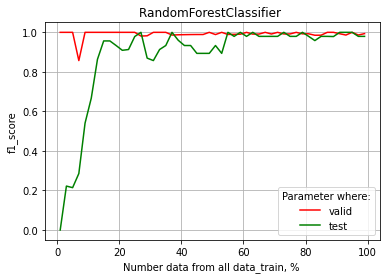

In [28]:
condition = lambda x: x*scaled_data_train.shape[0]
vfunc = np.vectorize(condition)
res = vfunc(array_step)
x_ = np.around(array_step, decimals=2)*100 
print("Size of test", scaled_data_test.shape[0])
fig, ax = plt.subplots()
ax.plot(x_, f1_score_rfc_valid, color='red', label='valid')
ax.plot(x_, f1_score_rfc_test, color='green', label='test')
ax.set(xlabel='Number data from all data_train, % ', ylabel='f1_score',
       title='RandomForestClassifier ')
ax.grid()
plt.legend(title='Parameter where:')
plt.show()

### KNeighborsClassifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knc = KNeighborsClassifier(10)
f1_score_knc_valid, f1_score_knc_test = [], []
array_step = []
step = 0.01
while step < 1:
    step = np.around(step, decimals=2)
    scaled_data_train_semi, scaled_data_valid_semi, y_train_semi, y_valid_semi = train_test_split(scaled_data_train, 
                                                                                              y_train, test_size=step, 
                                                                                              random_state=42)
    knc.fit(scaled_data_valid_semi, y_valid_semi)
    semi_outliers_valid = knc.predict(scaled_data_valid_semi)
    semi_outliers_test = knc.predict(scaled_data_test)
      
    f1_score_knc_valid.append(f1_score(y_valid_semi,  semi_outliers_valid, average='binary'))
    f1_score_knc_test.append(f1_score(y_test, semi_outliers_test, average='binary'))
    
    array_step.append(step)
    step += 0.1 


Size of test 3000


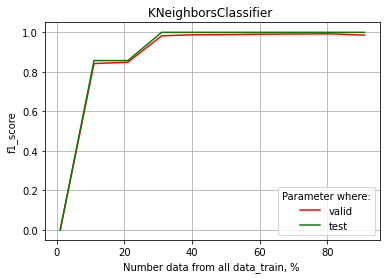

In [31]:
condition = lambda x: x*scaled_data_train.shape[0]
vfunc = np.vectorize(condition)
res = vfunc(array_step)
x_ = np.around(array_step, decimals=2)*100 
print("Size of test", scaled_data_test.shape[0])
fig, ax = plt.subplots()
ax.plot(x_, f1_score_knc_valid, color='red', label='valid')
ax.plot(x_, f1_score_knc_test, color='green', label='test')
ax.set(xlabel='Number data from all data_train, % ', ylabel='f1_score',
       title='KNeighborsClassifier ')
ax.grid()
plt.legend(title='Parameter where:')
plt.show()